# Import and function definition

In [1]:
from math import ceil

import joblib
import os 
import glob
import matplotlib.pyplot as plt
from pprint import pprint

import numpy as np
%matplotlib notebook

In [2]:
def open_simulation_files(simulation_folder):
    pprint(os.path.join(simulation_folder, 'test_record.jbl'))
    test = joblib.load(os.path.join(simulation_folder, 'test_record.jbl'))
    simulation = joblib.load(os.path.join(simulation_folder, 'simulation_params.jbl'))
    goal_sampler = joblib.load(os.path.join(simulation_folder, 'goal_sampler_record.jbl'))    
    # log = joblib.load(os.path.join(simulation, 'log.log'))
    return test, simulation, goal_sampler

def load_simulation(simulation):
    test_record, simulation_params, goal_sampler_record = open_simulation_files(simulation)
    episodes = list(test_record.keys())
    flattened_record = flatten(test_record)
#     pprint(test_record)

    goal_records = goal_sampler_record['goals_record']
    reached_counter = {k:v['reached_counter'] for k,v in goal_records.items()}
    target_counter = {k:v['target_counter'] for k,v in goal_records.items()}
    discovery_records = {k:v['iter_discovery'] for k,v in goal_records.items()}
    return flattened_record, reached_counter, target_counter, discovery_records, episodes

def load_simulation_list(simulation_list):
    flattened_records = {}
    reached_counters = {}
    target_counters = {}
    discovery_records = {}
    episodes = [0]
    for simulation in simulation_list:
        test_records, reached, target, discovery, ep = load_simulation(simulation)
        if max(episodes) < max(ep):
            episodes = ep
#         test_record, simulation_params, goal_sampler_record = open_simulation_files(simulation)
#         test_record = flatten(test_record)
        for k,v in test_records.items():
            try:
                flattened_records[k].append(v)
            except KeyError:
                flattened_records[k] = [v]
        
        for k in reached.keys():
            try:
                reached_counters[k].append(reached[k])
                target_counters[k].append(target[k])
                discovery_records[k].append(discovery[k])
            except KeyError:
                reached_counters[k] = [reached[k]]
                target_counters[k] = [target[k]]
                discovery_records[k] = [discovery[k]]
        print('done')

    for k, v in flattened_records.items():
        u = np.full((len(simulation_list), len(episodes)), np.nan)
        for i in range(len(v)):
            u[i, :len(v[i])] = v[i]
        flattened_records[k] = u
    
    return flattened_records, reached_counters, target_counters, discovery_records, episodes

In [3]:
def flatten(d):
    deal_with_overall_results(d)
    def aux(d, out):
        for k,v in d.items():
            if isinstance(v, dict):
                aux(v, out)
            else:
                try:
                    out[k].append(v)
                except KeyError:
                    out[k] = [v]
                    
    out = {}
    for val in d.values():
        if isinstance(val, dict):
            aux(val, out)
    return out

def replace_key(d, key, replace_by):
    try:
        v = d.pop(key)
        d[replace_by] = v
    except KeyError:
        pass
    

def deal_with_overall_results(d):
    thing_list = list(list(d.values())[0].keys())
    for v in d.values():
        for t in thing_list:
            replace_key(v[t], 'overall', f'overall_{t}')
            

In [4]:
def incr_ij(i,j, n_cols):
    if j == n_cols - 1:
        return i+1, 0
    else:
        return i, j+1

def hide_empty_subplots(fig):
    for ax in fig.axes:
        if not ax.has_data():
            ax.set_visible(False)
            
def plot_average_success_rates(episodes, flattened_test_record, reached_counter=None, iter_discovery=None, ncols=3, 
                               std_record=None, fig_axes_tuple=(None, None), del_unused_axes=True, display_goal_sampler_info=True, name=''):
    nline = ceil(len(flattened_test_record) / ncols)
    fig, axes = fig_axes_tuple
    if fig is None:
        fig, axes = plt.subplots(nline, ncols, figsize=(15,15), sharex=True, sharey=True)
        plt.subplots_adjust(hspace=0.6)
        
    i, j = 0, 0
    for k,v in flattened_test_record.items():
        ax = axes[i,j]
        ax.plot(episodes, v, label=name)
        if std_record:
            ax.fill_between(episodes, v-std_record[k], v+std_record[k], alpha=0.5)
        ax.set_title(k, pad=15)
        ax.set_ylim(0,1.1)
        
        if display_goal_sampler_info:
            try:
                ax.text(1, 0.85, f'pos. ex:{reached_counter[k]} \n'
                                 f'disc:{iter_discovery[k]}',
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform=ax.transAxes)
            except KeyError:
                pass

        i,j = incr_ij(i, j, ncols)

    return fig, axes

def compare_average_success_rate(*folders):
    """
    each folders should be a tuple (name, path), path is a list of simulation records path and name is the simulation name
    """
    fig, axes = (None, None)
    for (name, f) in folders:
        flattened_records, reached_counters, target_counters, discovery_records, episodes = load_simulation_list(f)
        average_flattened = {k: np.mean(v, 0) for k,v in flattened_records.items()}
        std_flattened = {k: np.nanstd(v, 0) for k,v in flattened_records.items()}
        fig, axes = plot_average_success_rates(episodes=episodes, flattened_test_record=average_flattened, std_record=std_flattened, fig_axes_tuple=(fig, axes),
                                              del_unused_axes=False, display_goal_sampler_info=False, name=name)
    
    handles, labels = axes[0,0].get_legend_handles_labels()
    print('************************************', labels)
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle('Average success_rate on a test set evaluated per description in different condition during training')
    hide_empty_subplots(fig)
    return fig, axes

    
def plot_goal_record(reached_counter, target_counter):
    ind = np.arange(len(goal_records))  # the x locations for the groups
    width = 0.2     # the width of the bars

    fig, ax = plt.subplots(figsize=(20,5))
    ax.bar(ind, reached_counter.values(),width, color='r', label = 'reached_counter')
    ax.bar(ind+width, target_counter.values(),width, color='g', label = 'target_counter')

    ax.set_xticks(ind + width)
    ax.set_xticklabels(goal_records.keys())
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
    
    ax.legend()
    fig.tight_layout()
    
def load_and_plot(path):
    flattened_records, reached_counters, target_counters, discovery_records, episodes = load_simulation_list(path)
    reached_averaged = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in reached_counters.items()}
    average_discovery = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in discovery_records.items()}
    average_flattened = {k: np.mean(v, 0) for k,v in flattened_records.items()}
    std_flattened = {k: np.nanstd(v, 0) for k,v in flattened_records.items()}
    fig, axes = plot_average_success_rates(episodes, average_flattened, reached_averaged, std_record=std_flattened, iter_discovery=average_discovery)          
    hide_empty_subplots(fig)

In [14]:
# for g in glob.glob('results/simulation_<*'):
#     rep = g.split('_')[-2]
#     c = g.split("'")[-2].split('.')[-1]
#     os.rename(g, g.replace(rep, c))

# Plot one simulation

In [255]:
simulation_name = 'AttentionFlatQnet_7'
folders = glob.glob(f'results/simulation_{simulation_name}*')
print(folders)

['results/simulation_AttentionFlatQnet_7']


In [256]:
flattened_records, reached_counter, target_counter, discovery_records = load_simulation(folders[0])

'results/simulation_AttentionFlatQnet_7/test_record.jbl'


<IPython.core.display.Javascript object>


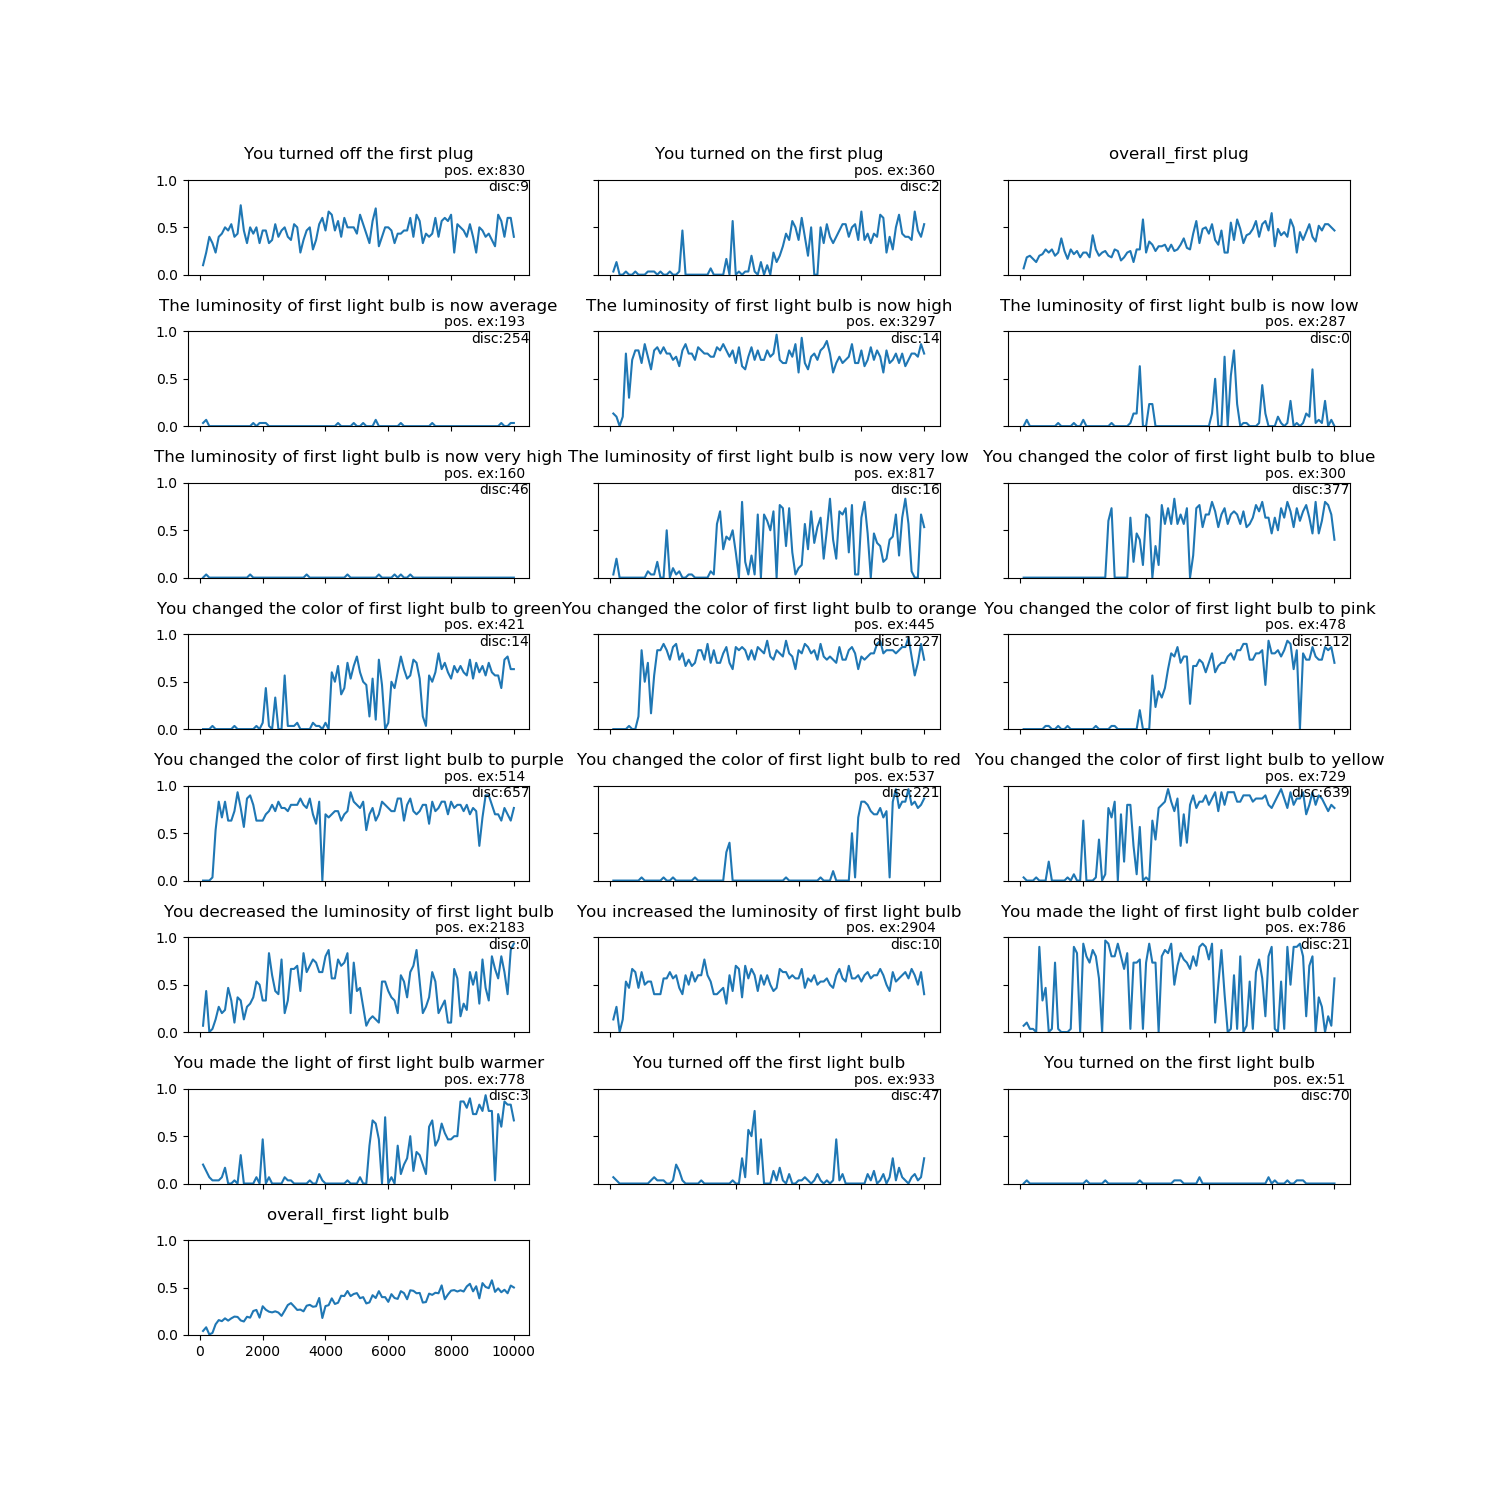

In [257]:
plot_average_success_rates(flattened_record, reached_counter, iter_discovery=discovery_records)

<IPython.core.display.Javascript object>


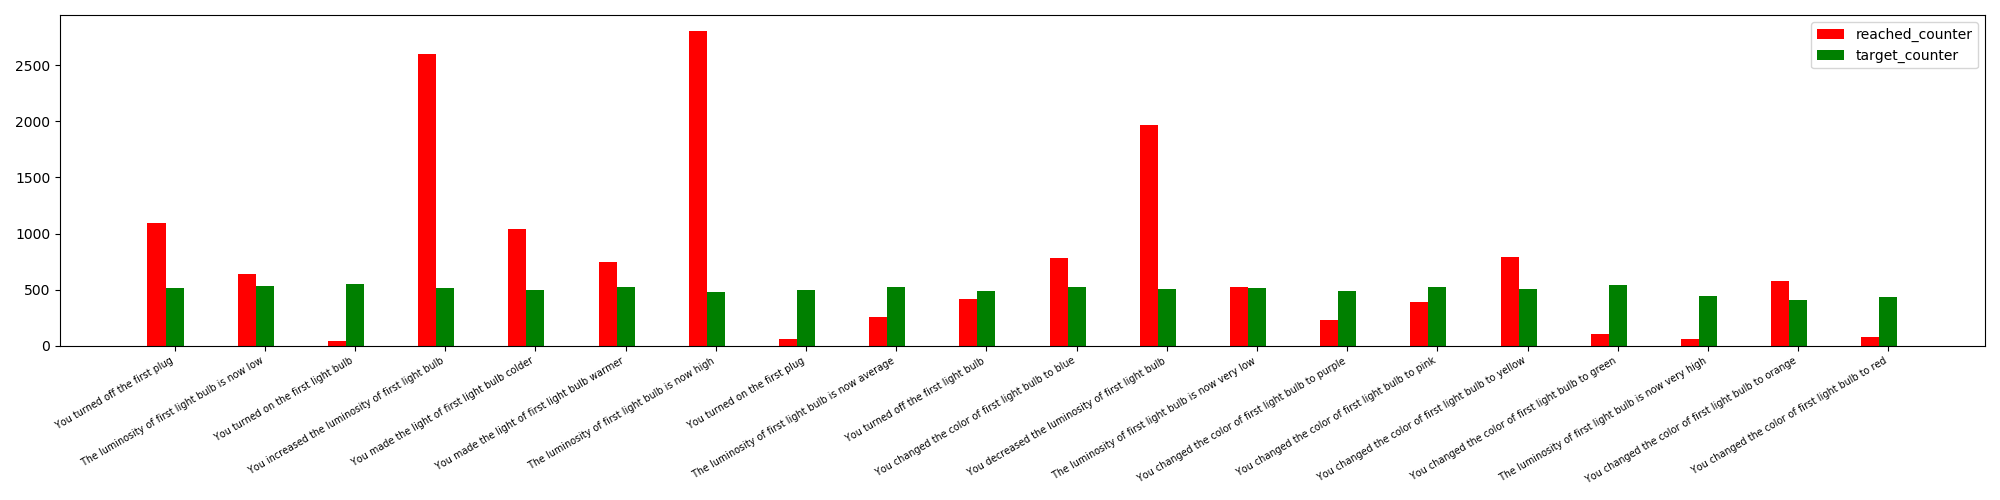

[Text(0, 0, 'You turned off the first plug'), Text(0, 0, 'The luminosity of first light bulb is now low'), Text(0, 0, 'You turned on the first light bulb'), Text(0, 0, 'You increased the luminosity of first light bulb'), Text(0, 0, 'You made the light of first light bulb colder'), Text(0, 0, 'You made the light of first light bulb warmer'), Text(0, 0, 'The luminosity of first light bulb is now high'), Text(0, 0, 'You turned on the first plug'), Text(0, 0, 'The luminosity of first light bulb is now average'), Text(0, 0, 'You turned off the first light bulb'), Text(0, 0, 'You changed the color of first light bulb to blue'), Text(0, 0, 'You decreased the luminosity of first light bulb'), Text(0, 0, 'The luminosity of first light bulb is now very low'), Text(0, 0, 'You changed the color of first light bulb to purple'), Text(0, 0, 'You changed the color of first light bulb to pink'), Text(0, 0, 'You changed the color of first light bulb to yellow'), Text(0, 0, 'You changed the color of firs

In [147]:
plot_goal_record(reached_counter, target_counter)

# Plot averaged simulation

In [47]:
# print(glob.glob(f'results/simulation_*'))
simulation_name = 'AttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/simulation_{simulation_name}*')
print(folders)

['results/simulation_AttentionFlatQnet_5', 'results/simulation_AttentionFlatQnet_9', 'results/simulation_AttentionFlatQnet_2', 'results/simulation_AttentionFlatQnet_10', 'results/simulation_AttentionFlatQnet_11', 'results/simulation_AttentionFlatQnet_4', 'results/simulation_AttentionFlatQnet_1', 'results/simulation_AttentionFlatQnet_8', 'results/simulation_AttentionFlatQnet_3', 'results/simulation_AttentionFlatQnet_6', 'results/simulation_AttentionFlatQnet_7']


In [48]:
flattened_records, reached_counters, target_counters, discovery_records, episodes = load_simulation_list(folders)
reached_averaged = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in reached_counters.items()}
average_discovery = {k: (np.round(np.mean(v)),np.round(np.std(v), 1)) for k,v in discovery_records.items()}
average_flattened = {k: np.mean(v, 0) for k,v in flattened_records.items()}
std_flattened = {k: np.std(v, 0) for k,v in flattened_records.items()}

'results/simulation_AttentionFlatQnet_5/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_9/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_2/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_10/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_11/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_4/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_1/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_8/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_3/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_6/test_record.jbl'
done
'results/simulation_AttentionFlatQnet_7/test_record.jbl'
done


<IPython.core.display.Javascript object>


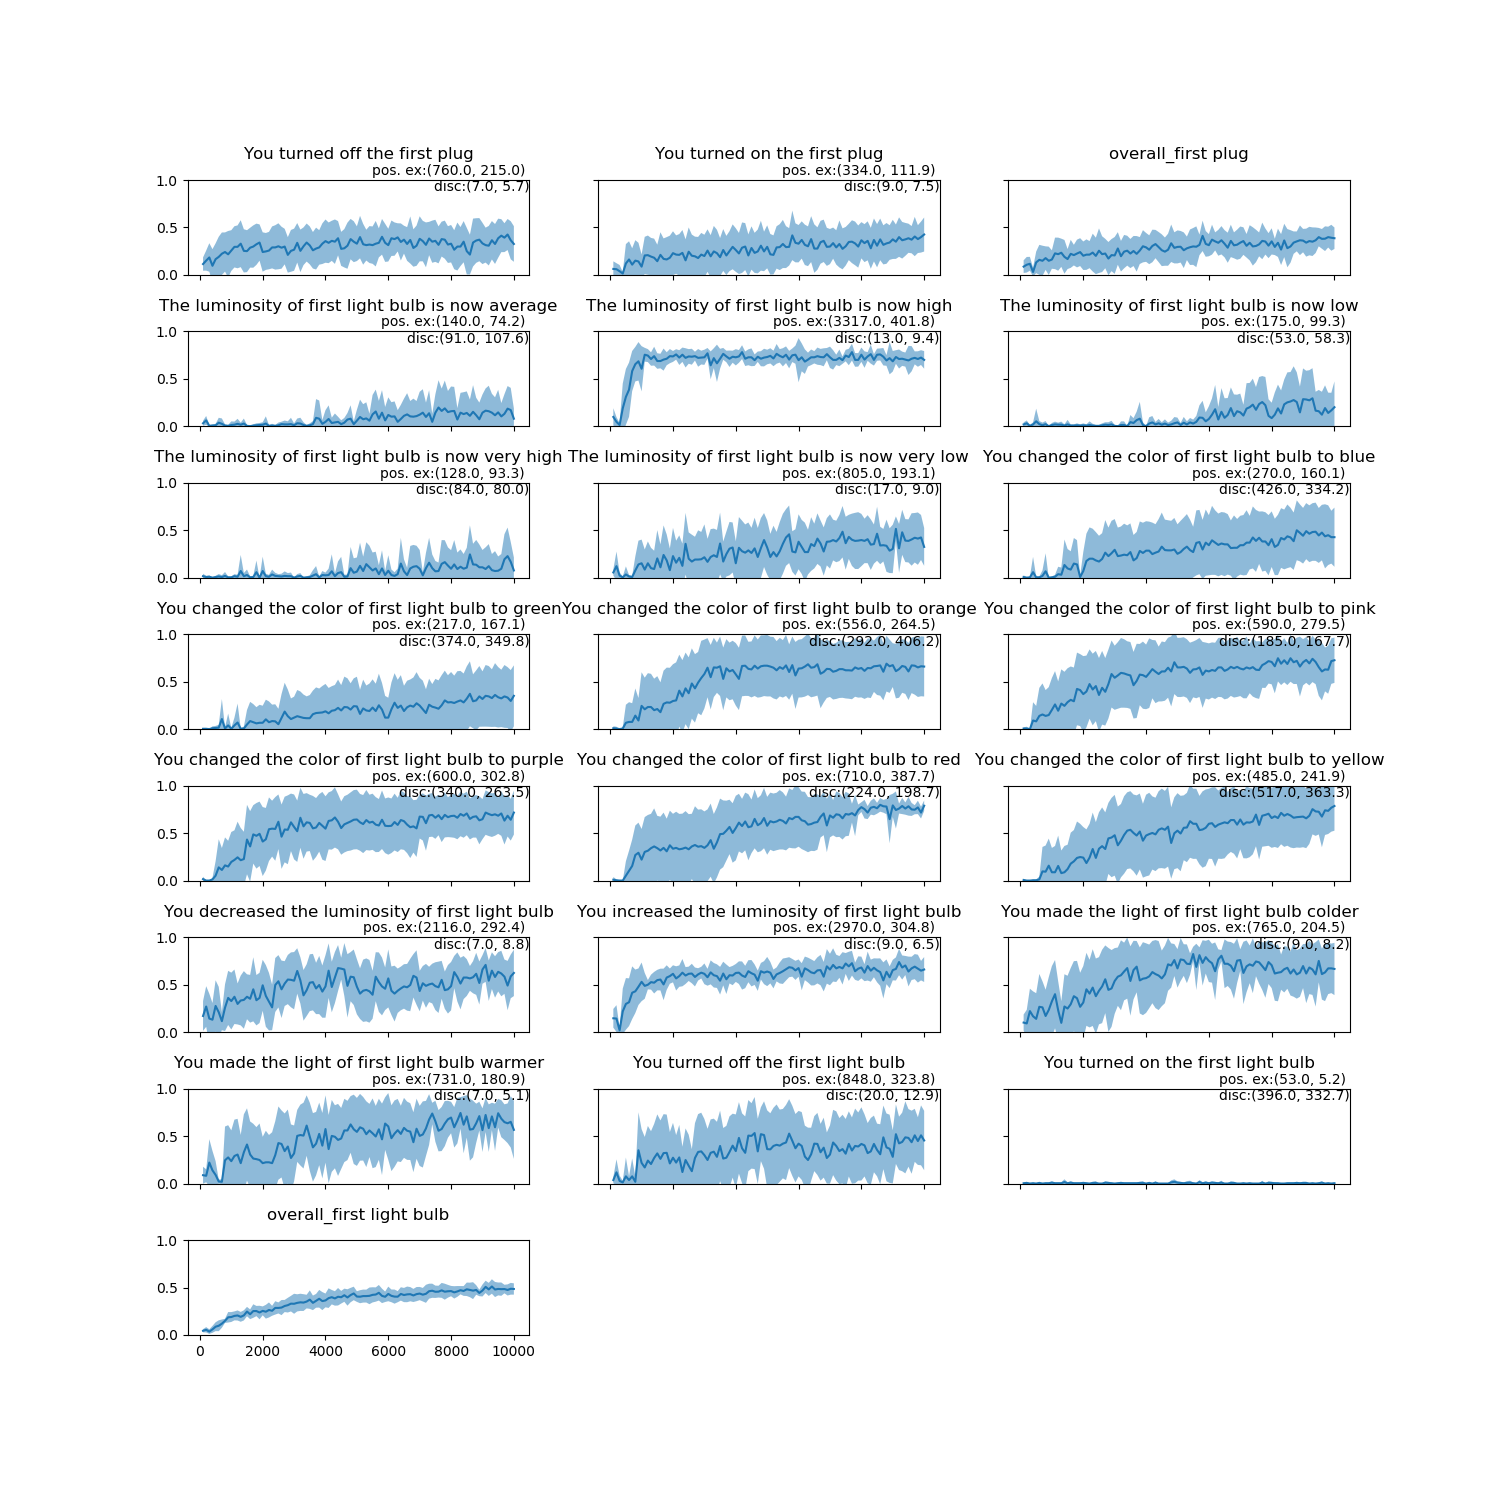

In [49]:
plot_average_success_rates(episodes, average_flattened, reached_averaged, std_record=std_flattened, iter_discovery=average_discovery)

# Usage

'results/third_round/simulation_NoAttentionFlatQnet_0/test_record.jbl'
done
'results/third_round/simulation_NoAttentionFlatQnet_3/test_record.jbl'
done
'results/third_round/simulation_NoAttentionFlatQnet_2/test_record.jbl'
done
'results/third_round/simulation_NoAttentionFlatQnet_1/test_record.jbl'
done


<IPython.core.display.Javascript object>


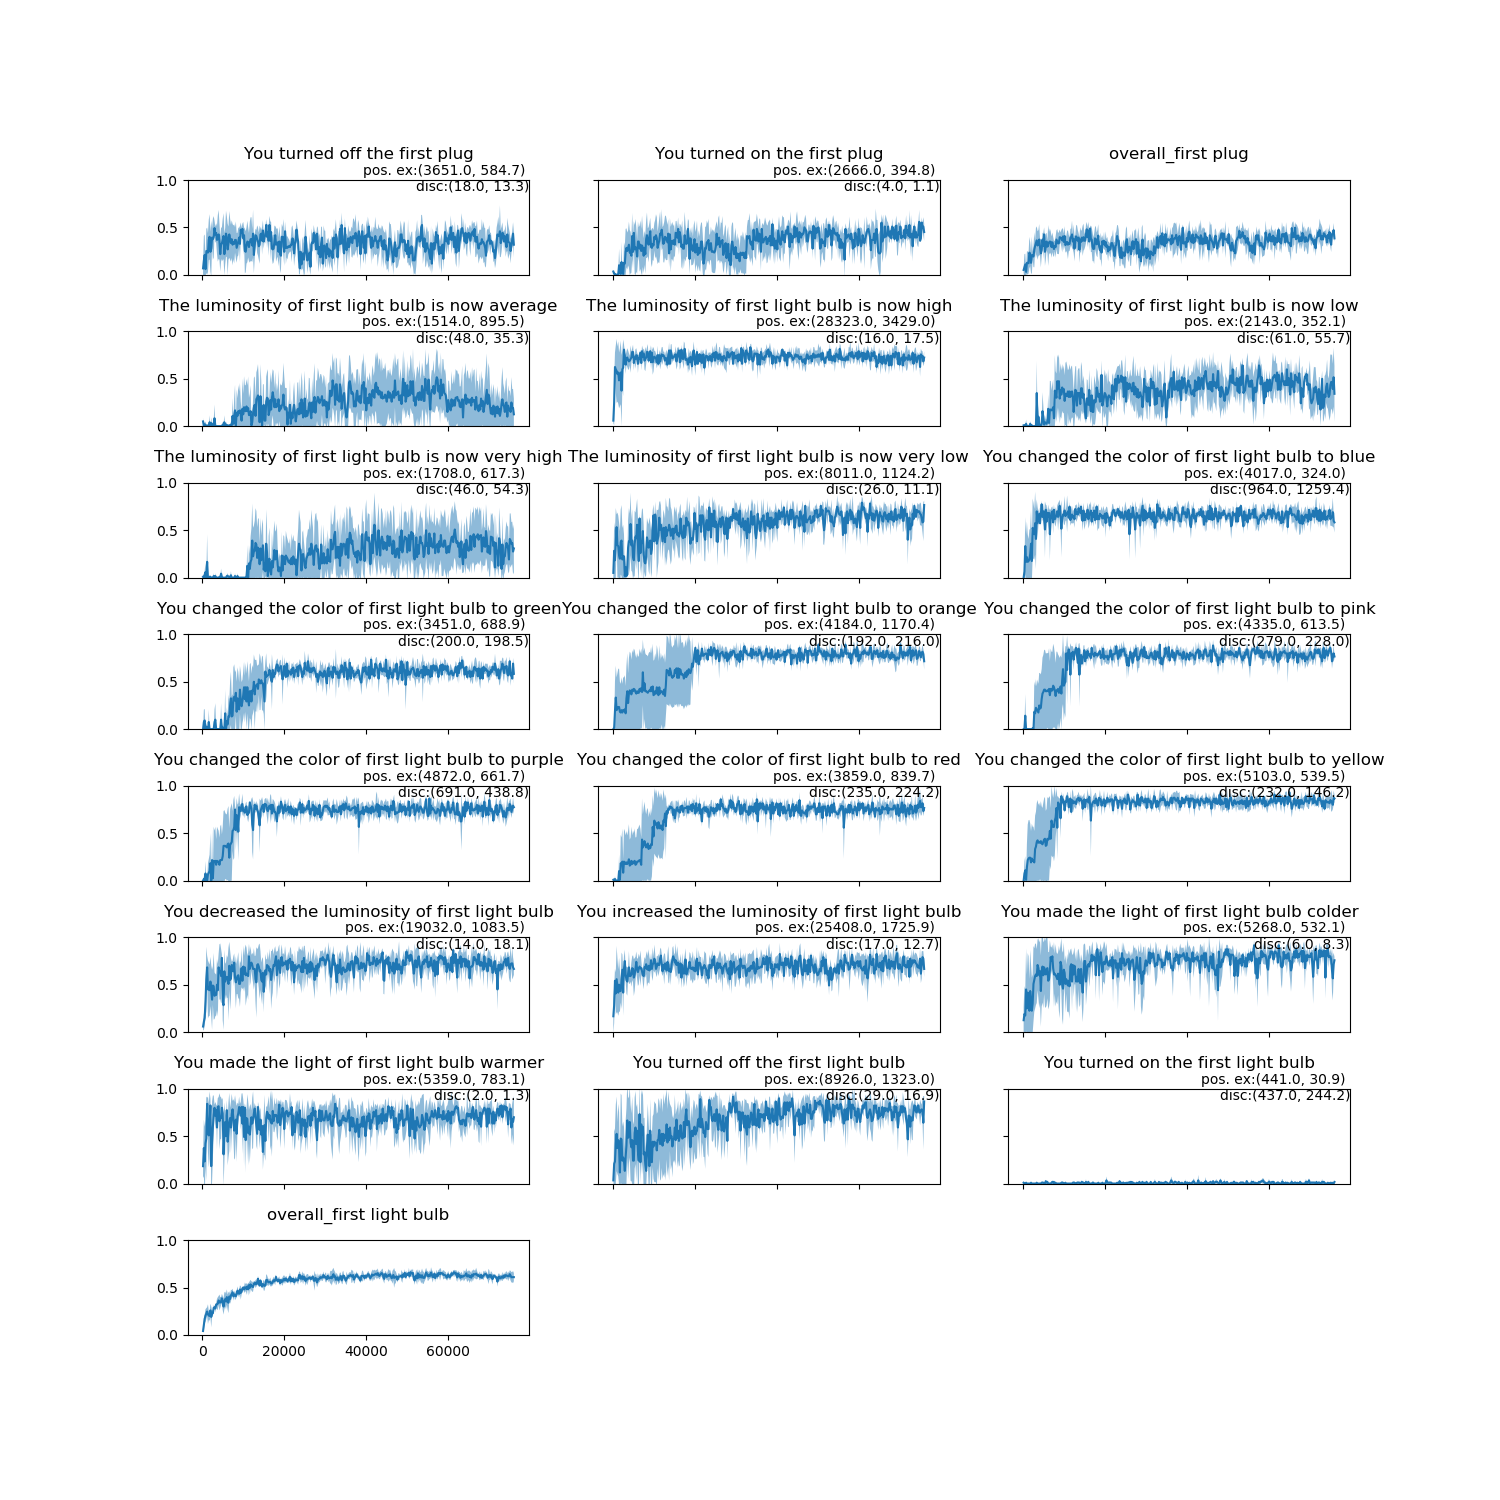

In [11]:
simulation_name = 'NoAttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/third_round/simulation_{simulation_name}*')
load_and_plot(folders)

'results/first_round/simulation_AttentionFlatQnet_5/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_9/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_2/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_10/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_11/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_4/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_1/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_8/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_3/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_6/test_record.jbl'
done
'results/first_round/simulation_AttentionFlatQnet_7/test_record.jbl'
done


<IPython.core.display.Javascript object>


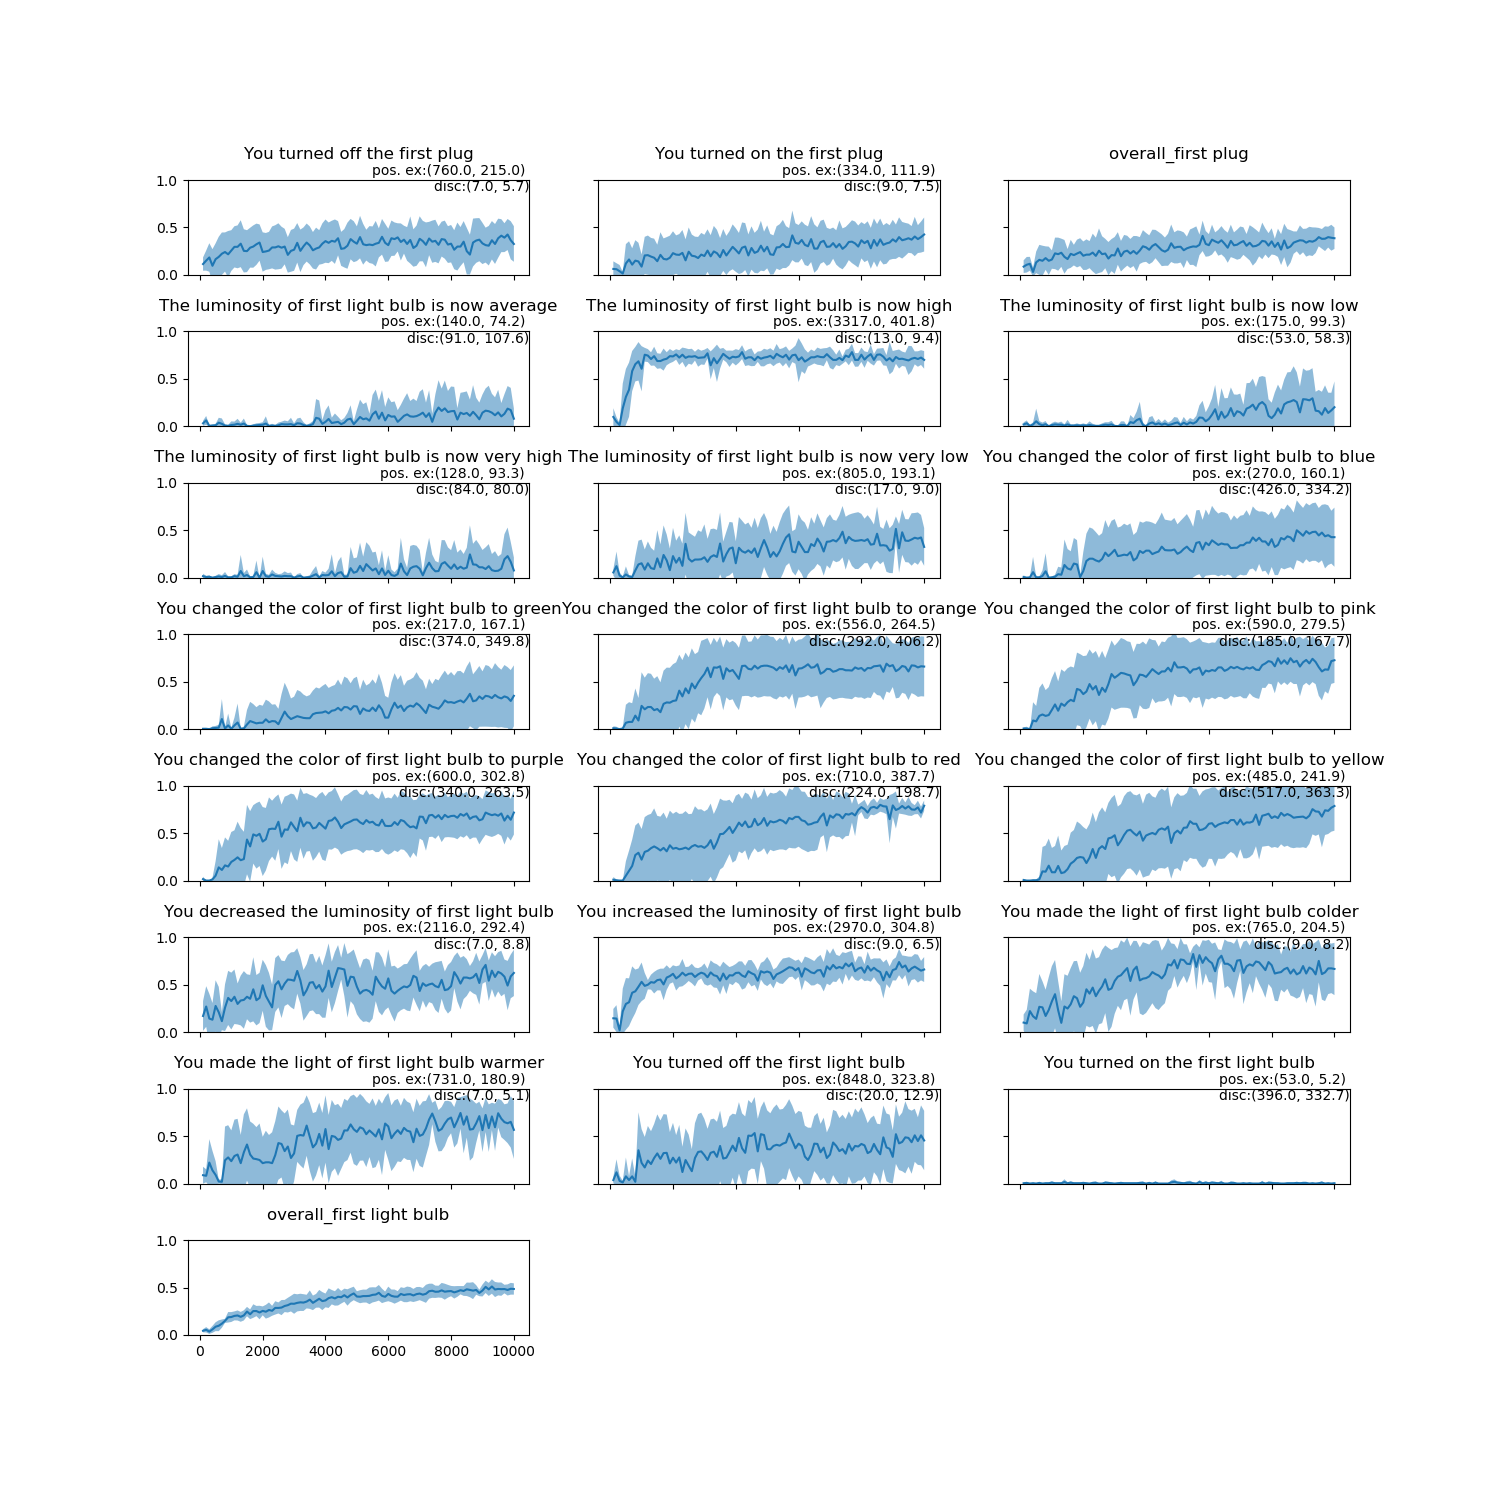

In [19]:
simulation_name = 'AttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/first_round/simulation_{simulation_name}*')
load_and_plot(folders)

'results/first_round/simulation_DeepSetQnet_8/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_3/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_1/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_11/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_7/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_5/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_2/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_9/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_6/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_4/test_record.jbl'
done
'results/first_round/simulation_DeepSetQnet_10/test_record.jbl'
done


<IPython.core.display.Javascript object>


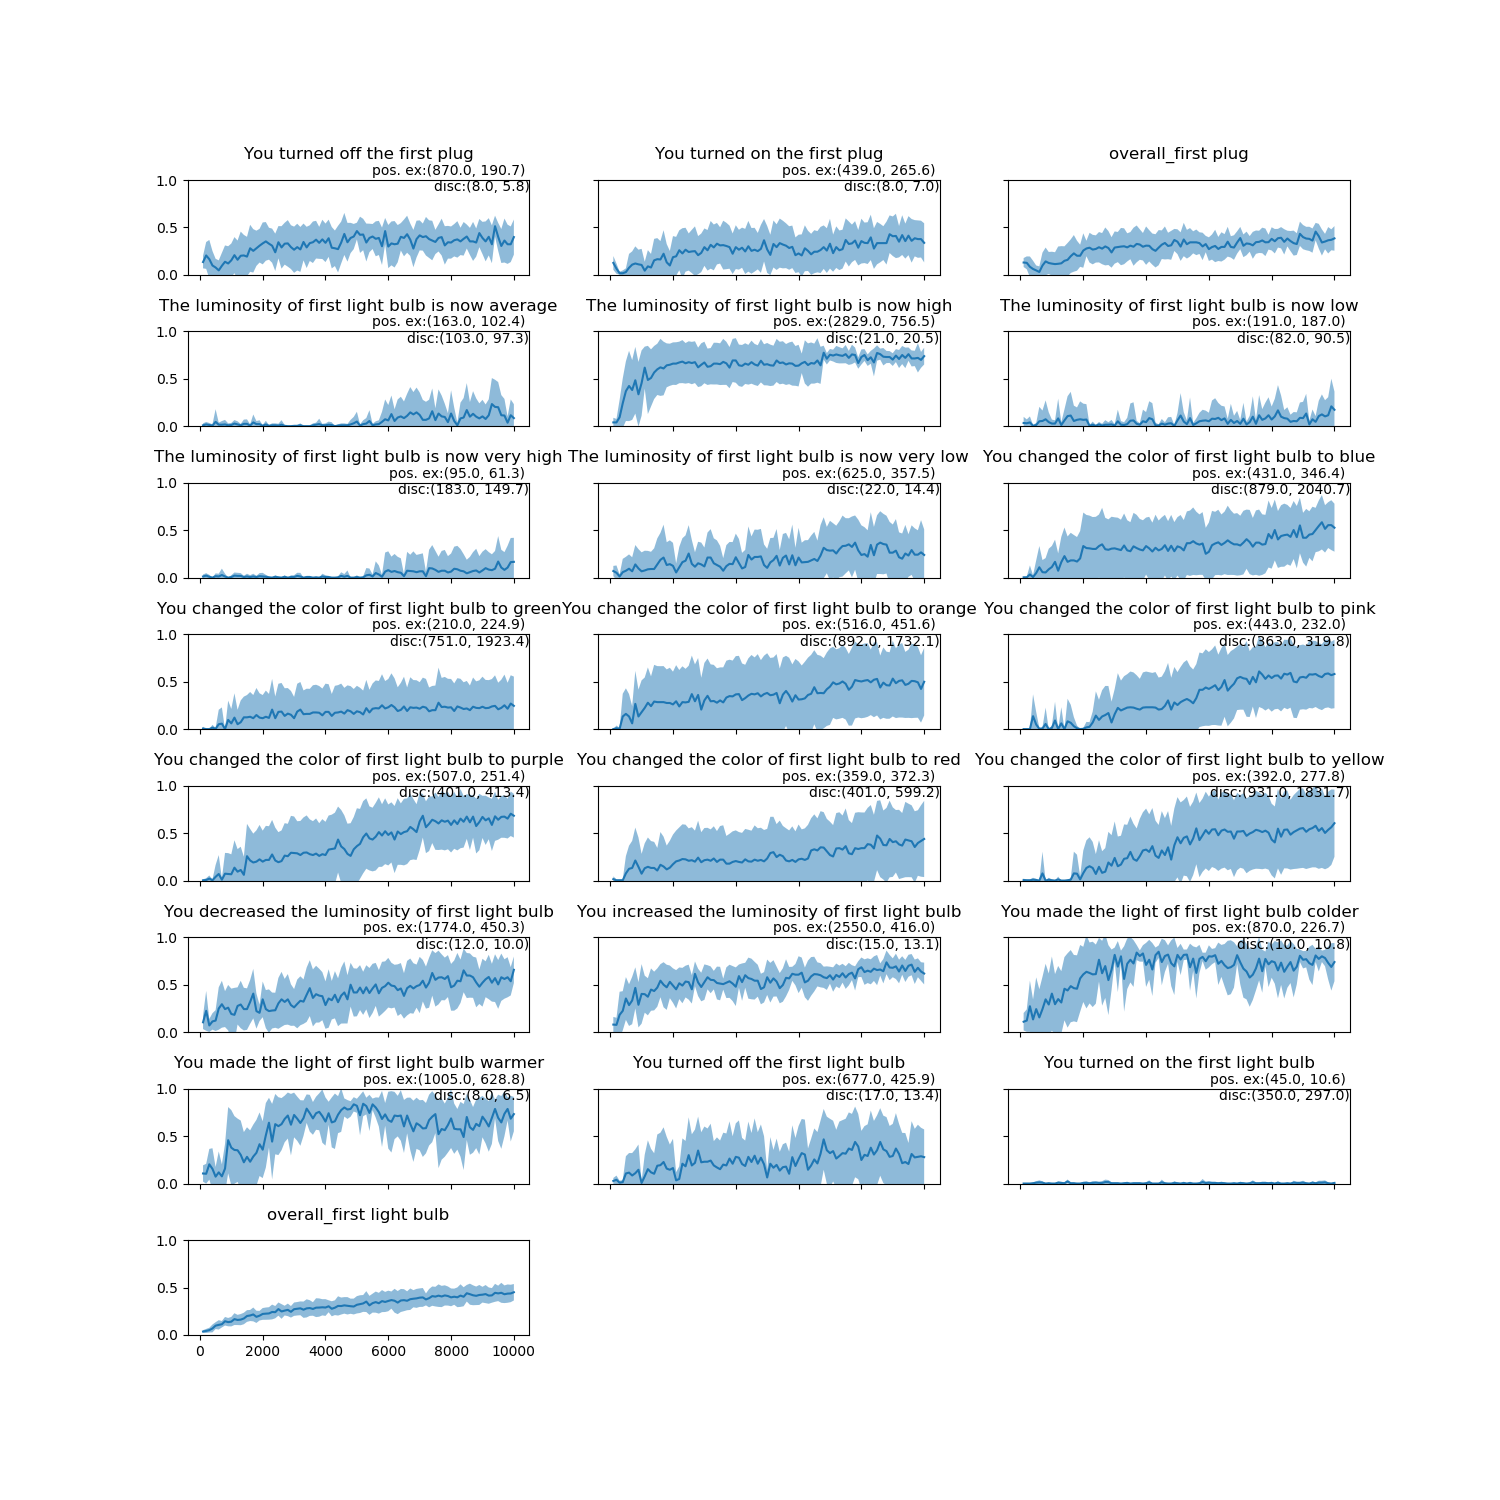

In [20]:
simulation_name = 'DeepSetQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/first_round/simulation_{simulation_name}*')
load_and_plot(folders)

'results/second_round/simulation_NoAttentionFlatQnet_0/test_record.jbl'
done
'results/second_round/simulation_NoAttentionFlatQnet_3/test_record.jbl'
done
'results/second_round/simulation_NoAttentionFlatQnet_4/test_record.jbl'
done
'results/second_round/simulation_NoAttentionFlatQnet_2/test_record.jbl'
done
'results/second_round/simulation_NoAttentionFlatQnet_1/test_record.jbl'
done


<IPython.core.display.Javascript object>


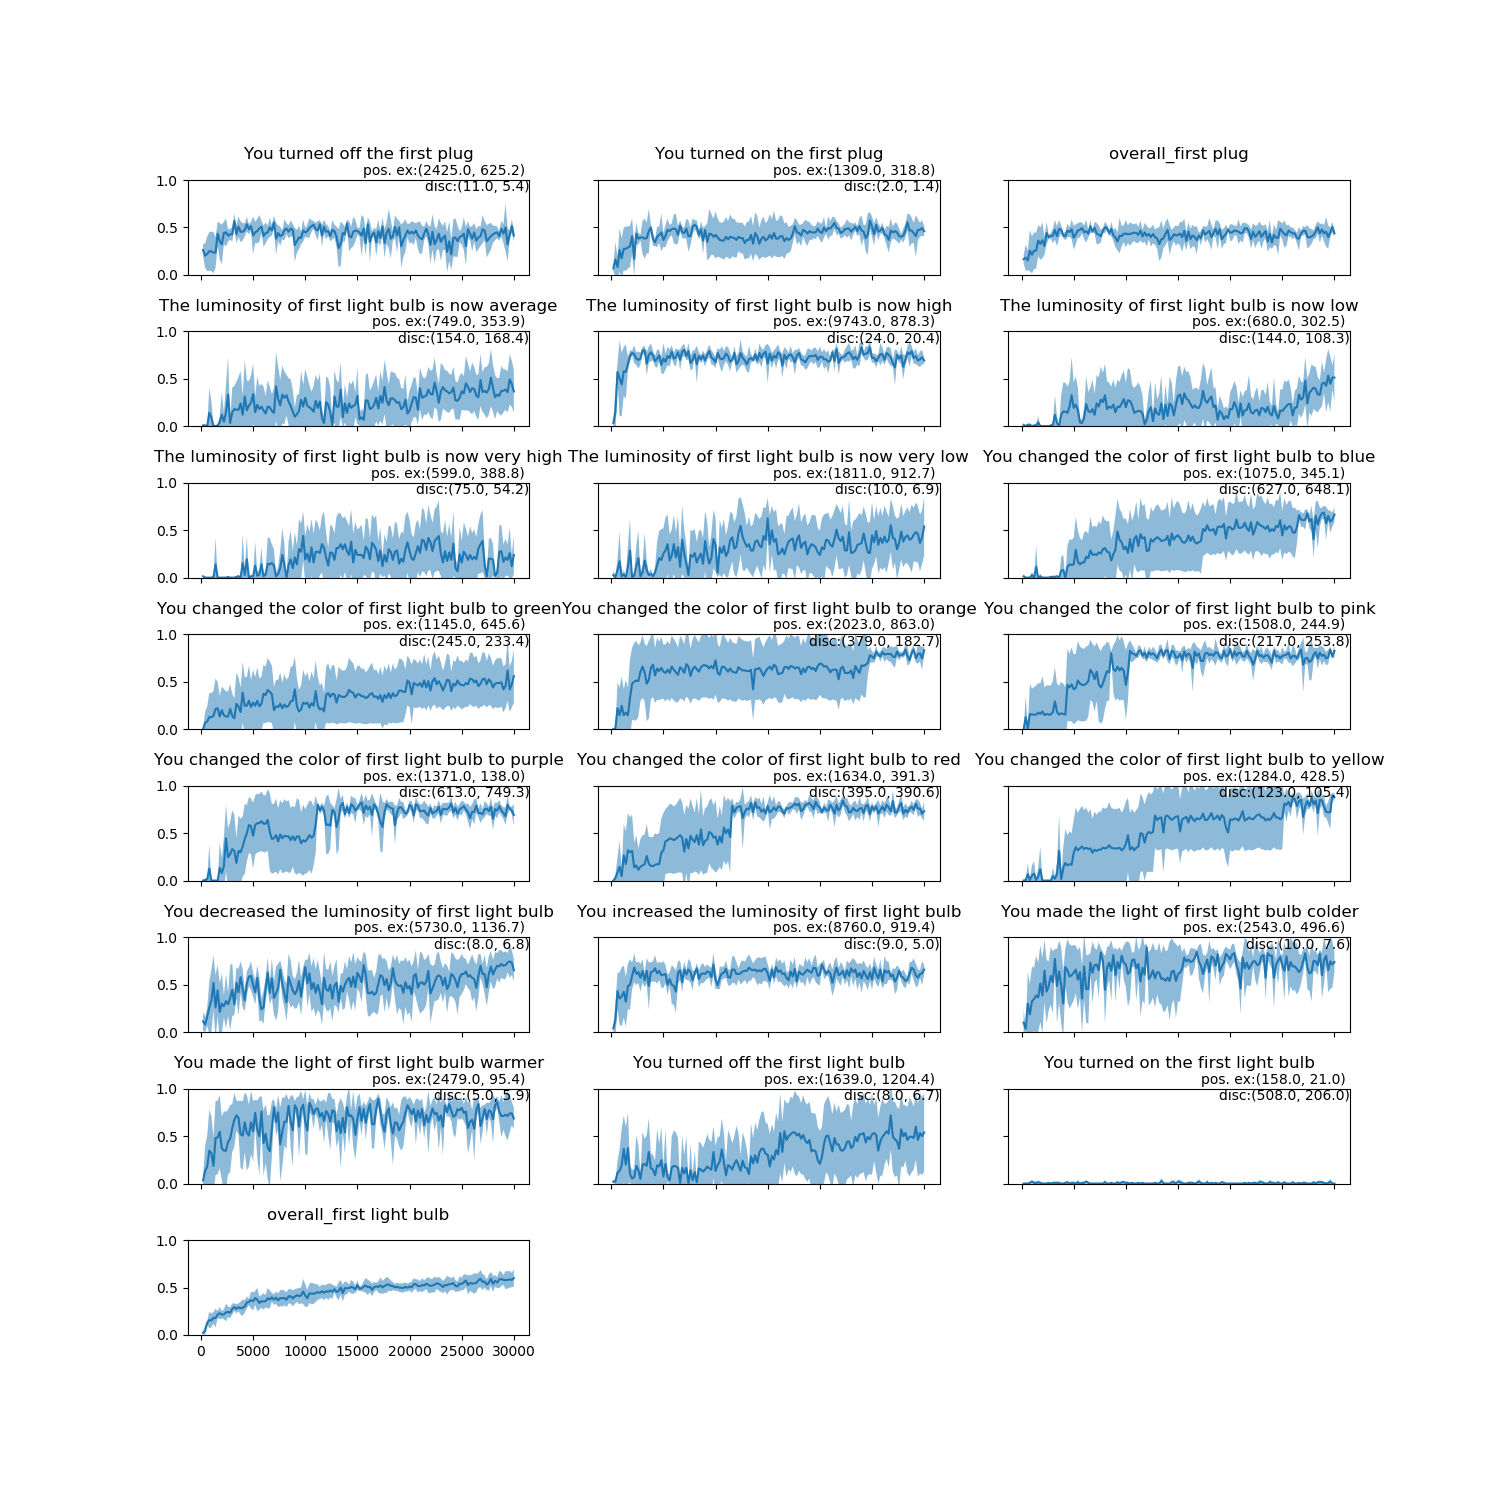

In [21]:
simulation_name = 'NoAttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/second_round/simulation_{simulation_name}*')
load_and_plot(folders)

'results/second_round/simulation_AttentionFlatQnet_2/test_record.jbl'
done
'results/second_round/simulation_AttentionFlatQnet_4/test_record.jbl'
done
'results/second_round/simulation_AttentionFlatQnet_1/test_record.jbl'
done
'results/second_round/simulation_AttentionFlatQnet_3/test_record.jbl'
done
'results/second_round/simulation_AttentionFlatQnet_0/test_record.jbl'
done


<IPython.core.display.Javascript object>


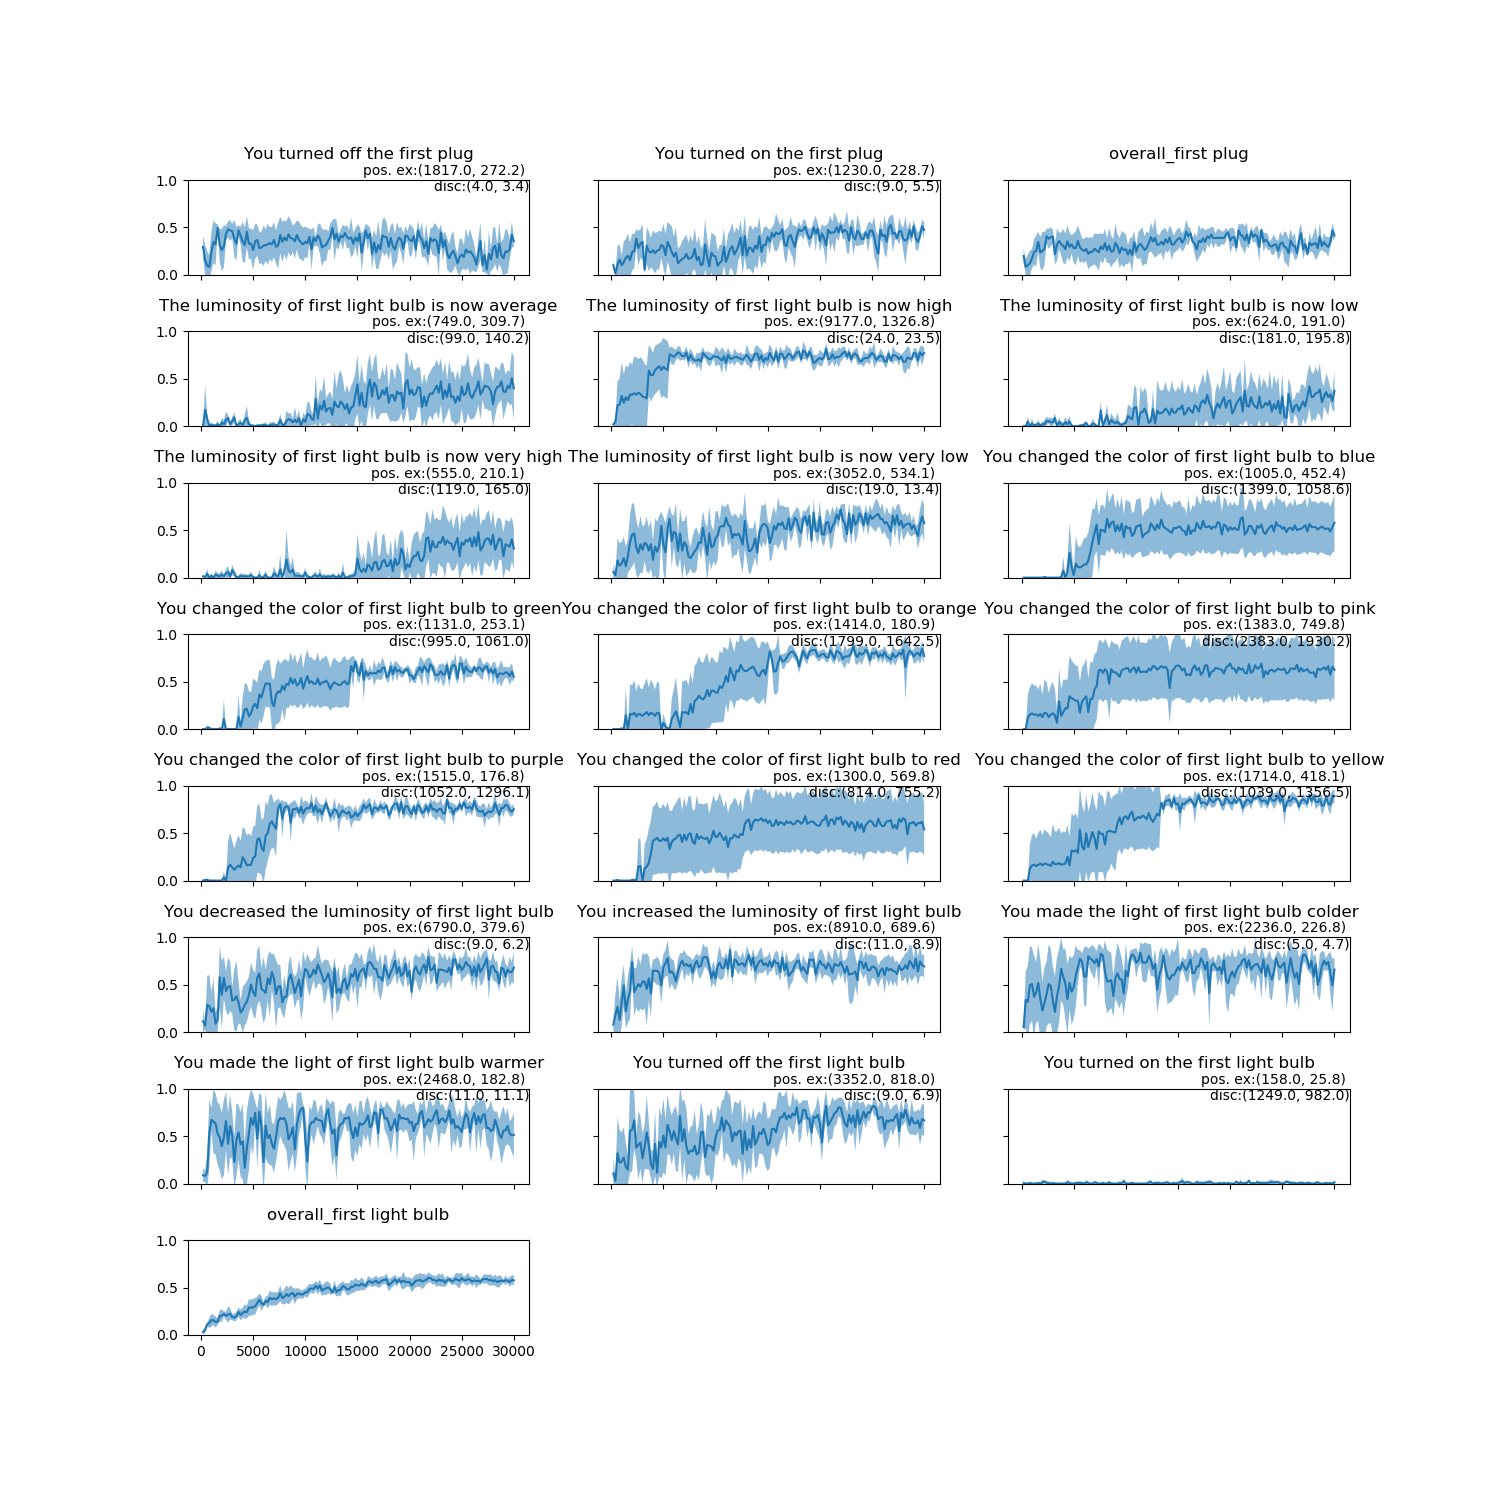

In [22]:
simulation_name = 'AttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/second_round/simulation_{simulation_name}*')
load_and_plot(folders)

'results/second_round/simulation_DeepSetQnet_3/test_record.jbl'
done
'results/second_round/simulation_DeepSetQnet_1/test_record.jbl'
done
'results/second_round/simulation_DeepSetQnet_0/test_record.jbl'
done
'results/second_round/simulation_DeepSetQnet_2/test_record.jbl'
done
'results/second_round/simulation_DeepSetQnet_4/test_record.jbl'
done


<IPython.core.display.Javascript object>


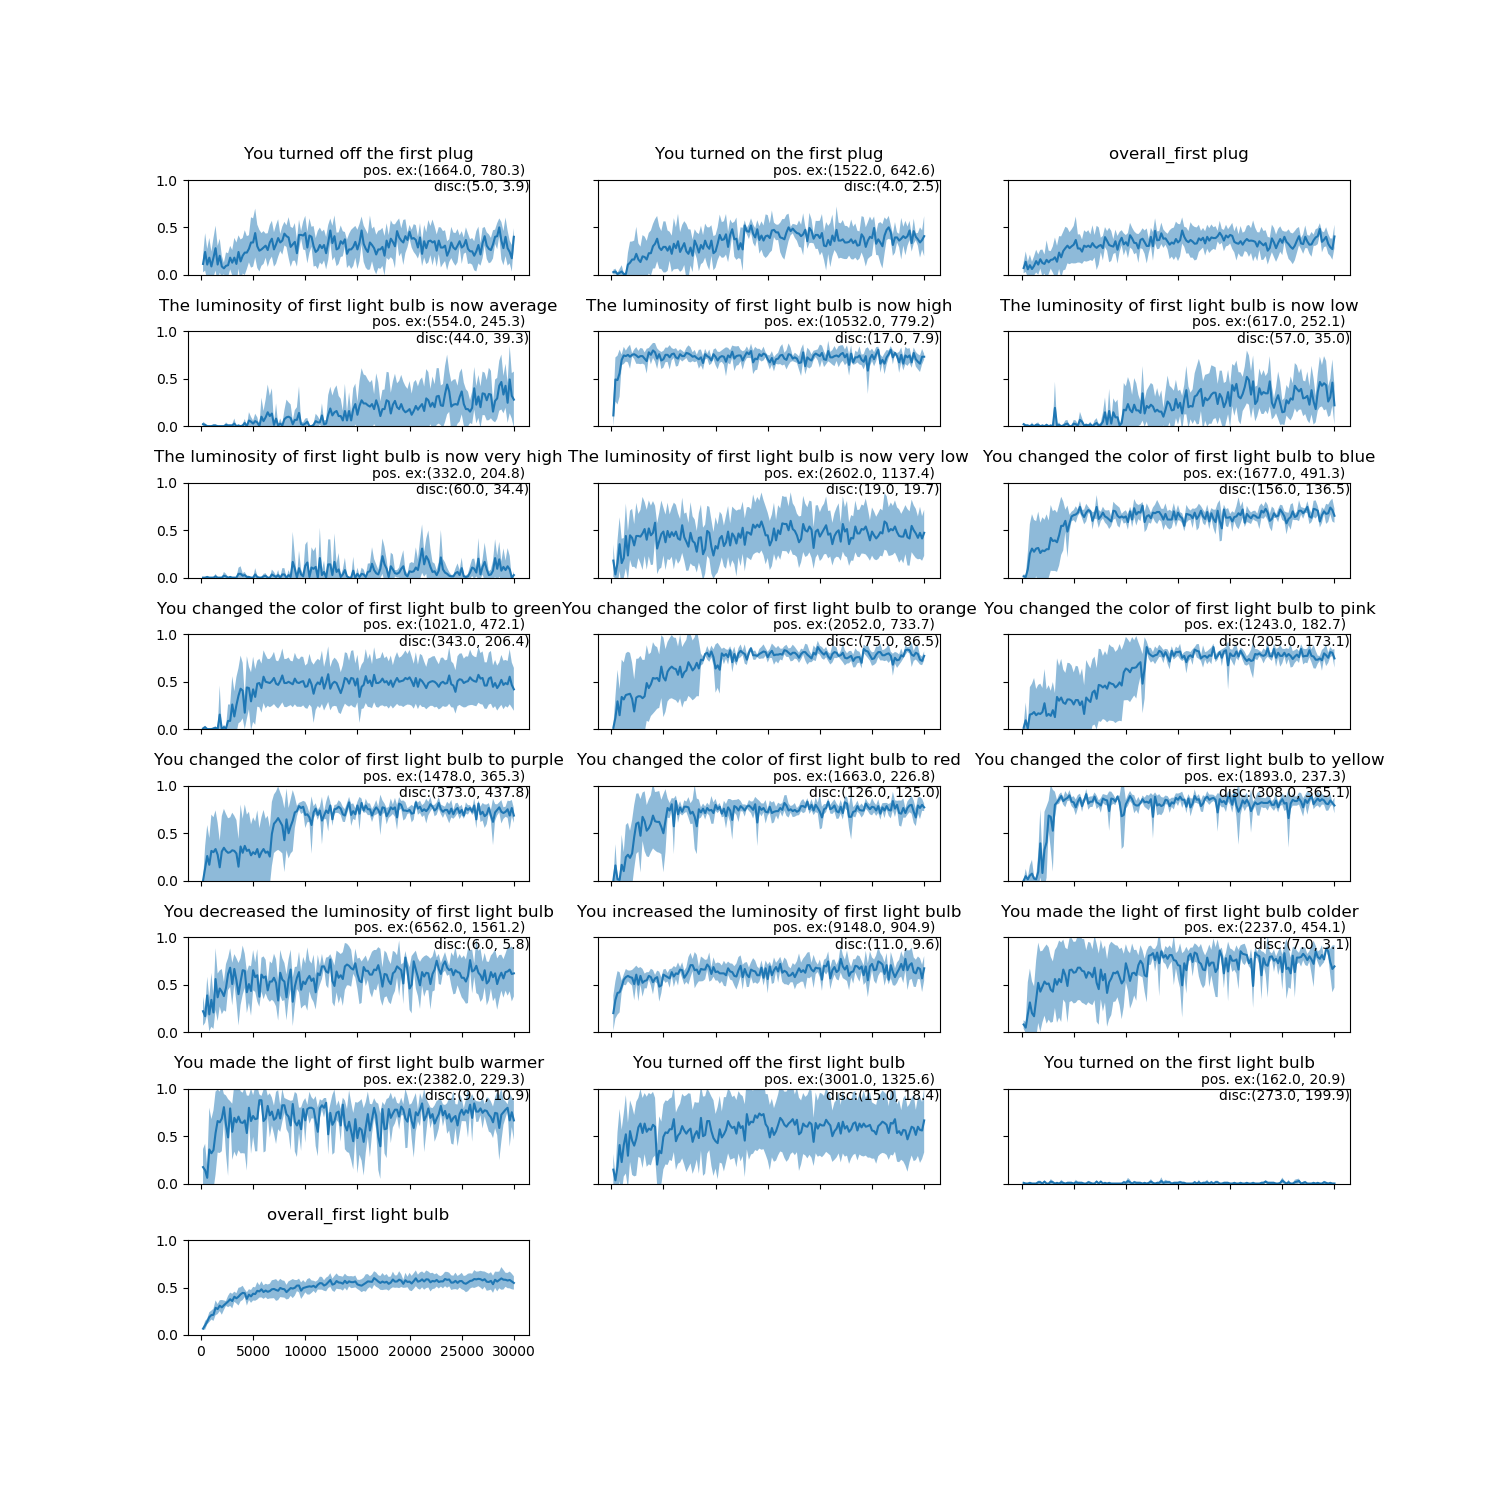

In [23]:
simulation_name = 'DeepSetQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/second_round/simulation_{simulation_name}*')
load_and_plot(folders)

'results/Simulation pretrained LM/simulation_pretrained_lm_5/test_record.jbl'
done
'results/Simulation pretrained LM/simulation_pretrained_lm_0/test_record.jbl'
done
'results/Simulation pretrained LM/simulation_pretrained_lm_1/test_record.jbl'
done
'results/Simulation pretrained LM/simulation_pretrained_lm_2/test_record.jbl'
done


<IPython.core.display.Javascript object>


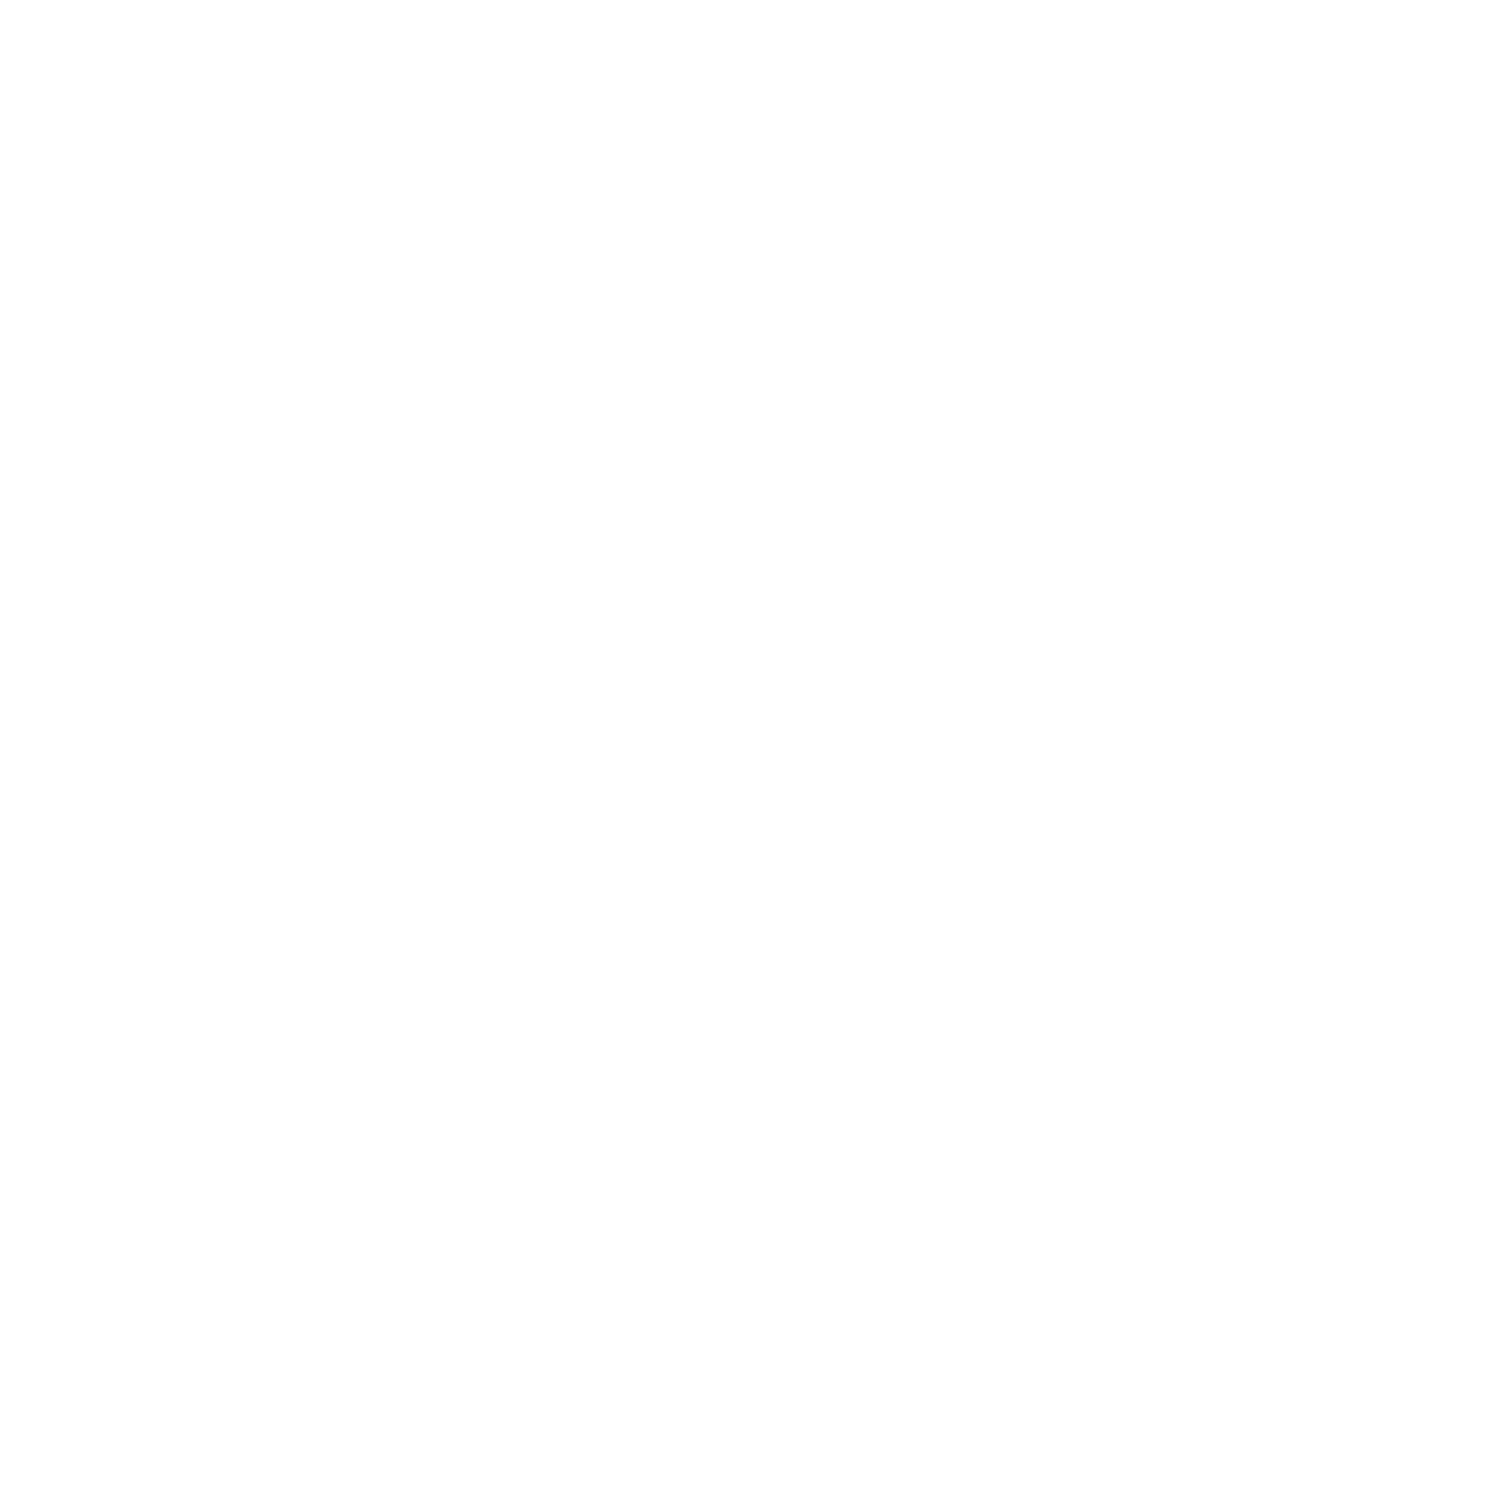

In [10]:
simulation_name = 'pretrained_lm' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
folders = glob.glob(f'results/Simulation pretrained LM/simulation_{simulation_name}*')
load_and_plot(folders)

# Comparision

'results/mse_pretrained_lm/simulation_mse_pretrained_lm_2/test_record.jbl'
done
'results/mse_pretrained_lm/simulation_mse_pretrained_lm_4/test_record.jbl'
done
'results/mse_pretrained_lm/simulation_mse_pretrained_lm_5/test_record.jbl'
done
'results/mse_pretrained_lm/simulation_mse_pretrained_lm_6/test_record.jbl'
done


<IPython.core.display.Javascript object>


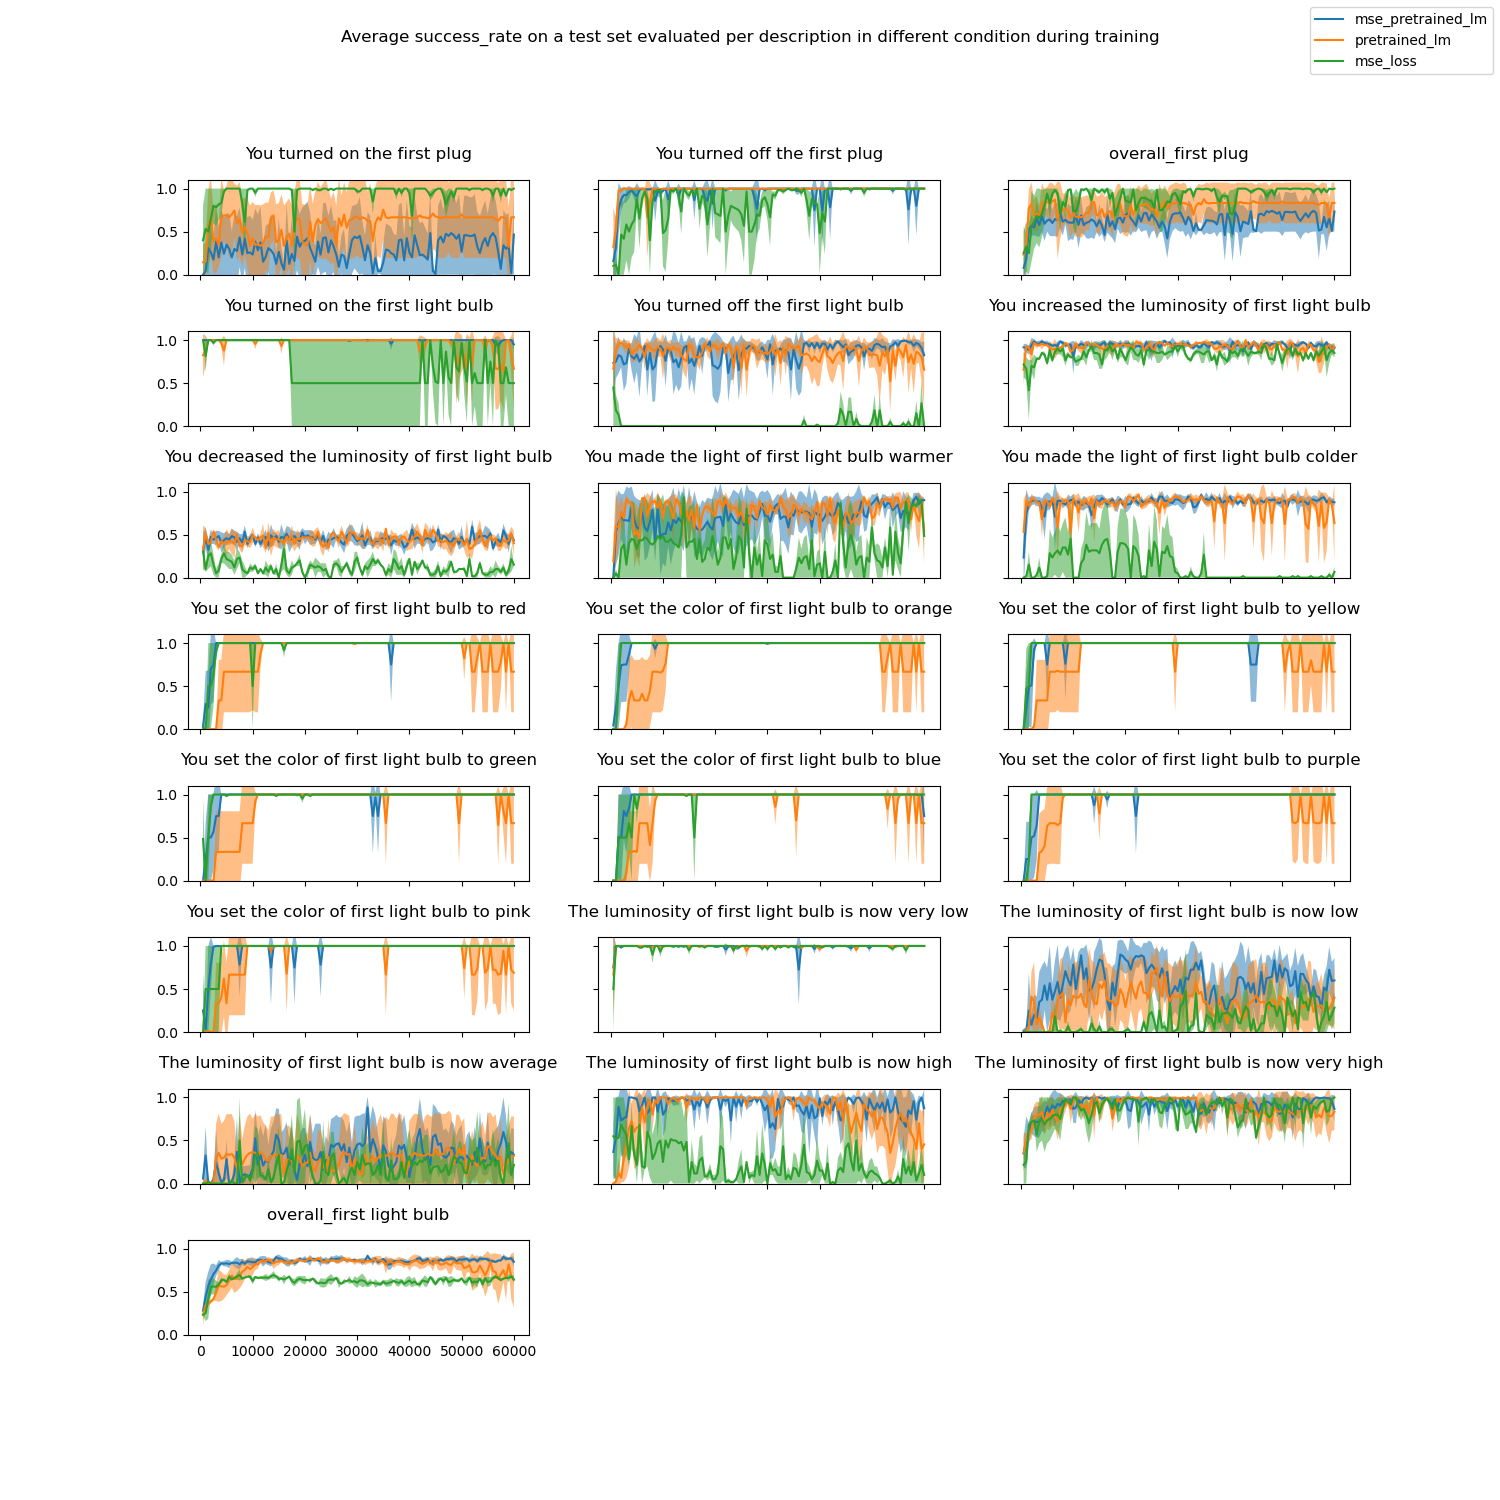

'results/pretrained_lm/simulation_pretrained_lm_5/test_record.jbl'
done
'results/pretrained_lm/simulation_pretrained_lm_0/test_record.jbl'
done
'results/pretrained_lm/simulation_pretrained_lm_3/test_record.jbl'
done
'results/mse_loss/simulation_mse_loss_5/test_record.jbl'
done
'results/mse_loss/simulation_mse_loss_2/test_record.jbl'
done
************************************ ['mse_pretrained_lm', 'pretrained_lm', 'mse_loss']


In [11]:
# simulation_name = 'NoAttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
# folders = glob.glob(f'results/third_round/simulation_{simulation_name}*')
# load_and_plot(folders)

# s1 = 'NoAttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
# f1 = glob.glob(f'results/second_round/simulation_{s1}*')

# s2 = 'AttentionFlatQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
# f2 = glob.glob(f'results/second_round/simulation_{s2}*')

# s3 = 'DeepSetQnet' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
# f3 = glob.glob(f'results/second_round/simulation_{s3}*')

# s4 = 'without_do_nothing' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
# f4 = glob.glob(f'results/without_do_nothing/simulation_pretrained_lm*')

# s5 = 'with_do_nothing' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
# f5 = glob.glob(f'results/with_do_nothing/simulation_pretrained_lm*')

s6 = 'mse_pretrained_lm' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
f6 = glob.glob(f'results/mse_pretrained_lm/*')


s7 = 'pretrained_lm' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
f7 = glob.glob(f'results/pretrained_lm/*')


s8 = 'mse_loss' #'DeepSetQnet' # 'NoAttentionFlatQnet' #  'AttentionFlatQnet'
f8 = glob.glob(f'results/mse_loss/*')


# fig, axes = compare_average_success_rate((s1, f1), (s2, f2), (s3, f3), (s4, f4))
fig, axes = compare_average_success_rate((s6, f6), (s7, f7), (s8, f8))

'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_0/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_8/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_24/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_20/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_25/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_2/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_13/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_7/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_12/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_6/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_no_pretrained_4/test_record.jbl'
done
'results/batch_mse_no_pretrained/simulation_mse_n

<IPython.core.display.Javascript object>


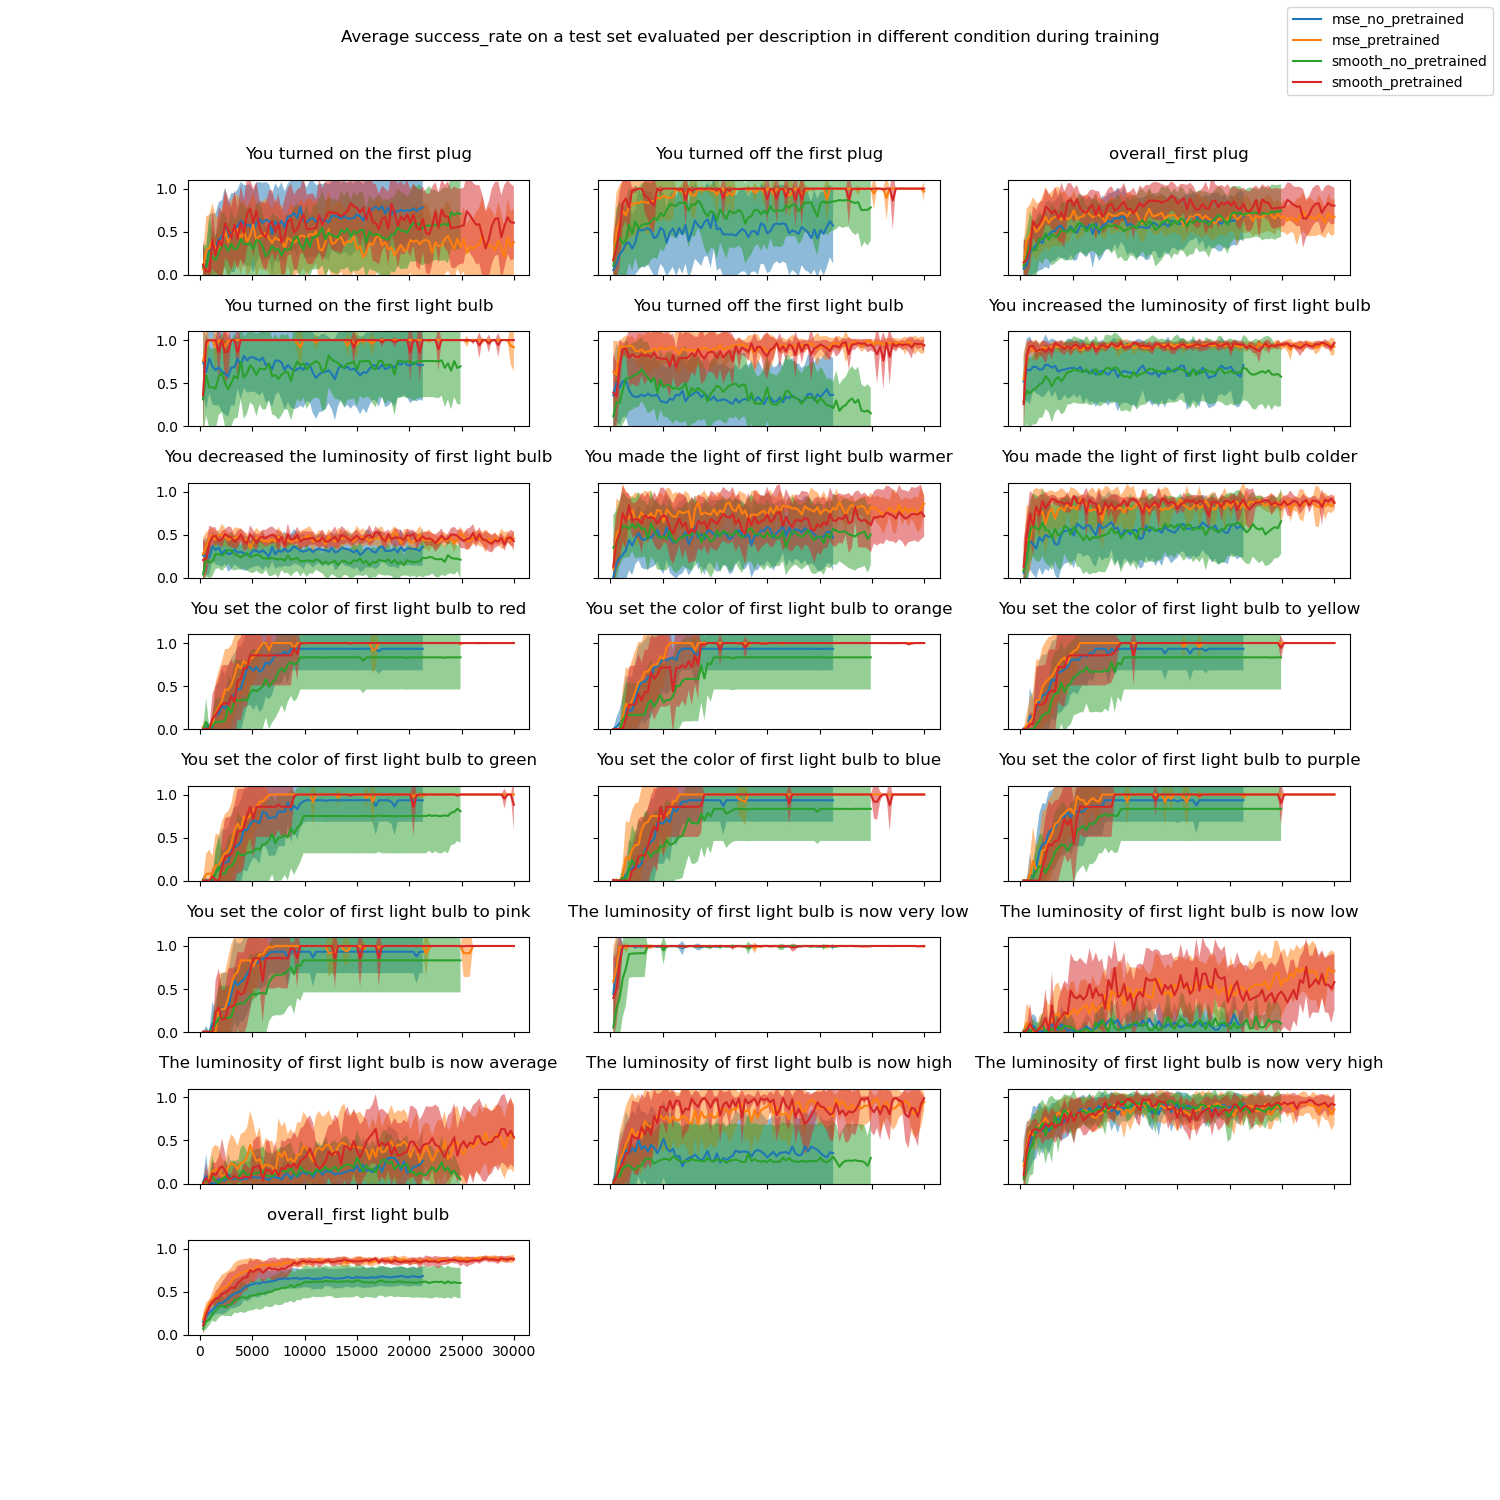

'results/batch_mse_pretrained/simulation_mse_pretrained_35/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_14/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_10/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_22/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_15/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_7/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_20/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_27/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_16/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_9/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_6/test_record.jbl'
done
'results/batch_mse_pretrained/simulation_mse_pretrained_17/test_record.jbl'
done
'results/batch_smooth_no_pretra

In [5]:
s = 'mse_no_pretrained'
f6 = (s,glob.glob(f'results/batch_{s}/*'))

s = 'mse_pretrained'
f7 = (s,glob.glob(f'results/batch_{s}/*'))

s = 'smooth_no_pretrained'
f8 = (s,glob.glob(f'results/batch_{s}/*'))

s = 'smooth_pretrained'
f9 = (s,glob.glob(f'results/batch_{s}/*'))


# fig, axes = compare_average_success_rate((s1, f1), (s2, f2), (s3, f3), (s4, f4))
fig, axes = compare_average_success_rate(f6,f7, f8,f9)

In [6]:
10000/20

500.0